In [1]:
# Cell: Imports
from __future__ import annotations

import ast
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import onnx
import onnxruntime as ort
import random
import librosa
from IPython.display import Audio, display

from src.config import (
    BACKGROUND_LABEL,
    HOP_LENGTH,
    LABEL_TO_ID,
    N_FFT,
    N_MELS,
    NUM_CLASSES,
    SEED,
    SR,
    PROJECT_ROOT
)
from src.inference import load_torch_checkpoint


In [2]:
# Cell: Configuration
# 你只需要改这一段即可（路径/折号/比例/静态输入帧数）

OUTPUT_DIR = Path("cache/exports")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 输入：要导出的 .pt checkpoint（来自训练或手工挑选）
PT_PATH = Path("cache/experiments/tinyglassnet_best.pt")

# 输入：训练/缓存阶段生成的 window 索引（用于导出 test/calib 数据）
INDEX_CSV = Path("cache/window_index.csv")

# 选择一个验证折，用于导出 test_fold.npz
VAL_FOLD = 5

MODEL_NAME = "tiny-audio-net"

# calib 抽样比例（从 train folds 抽取）
CALIB_RATIO = 0.10
CALIB_SEED = 42

# ONNX 静态输入的时间帧数（None 表示自动从索引里读取第一个 mel 的 T）
# 注意：如果你缓存已经裁到 84，这里建议固定 84。
ONNX_STATIC_FRAMES: int | None = None

# 单样本导出：给一个 2D mel npy (64,T)，导出成 4D (1,1,64,T)
WINDOW_NPY = Path("backup/cache/mel64/gunshot/fold2/3 (70)_3 (70)_w0.npy")


In [3]:
# Cell: Helpers
BACKGROUND_ID = -1  # 用于单标签 labels 字段；multi-hot y 里 background 用全 0 表示


def load_index_df_with_parsing(path: Path) -> pd.DataFrame:
    """Load index CSV and parse list-like columns (label_ids/labels) from strings."""
    df = pd.read_csv(path)
    if "label_ids" in df.columns:
        df["label_ids"] = df["label_ids"].apply(
            lambda v: ast.literal_eval(v) if isinstance(v, str) else (v if v is not None else [])
        )
    if "labels" in df.columns:
        df["labels"] = df["labels"].apply(
            lambda v: ast.literal_eval(v) if isinstance(v, str) else (v if v is not None else [])
        )
    return df


def subset_by_folds(df: pd.DataFrame, folds: list[int]) -> pd.DataFrame:
    return df[df["fold_id"].isin(folds)].reset_index(drop=True)


def row_to_label_ids(row: pd.Series) -> list[int]:
    """Best-effort conversion to label id list for multi-label BCE."""
    v = row.get("label_ids", [])
    if isinstance(v, (list, tuple, np.ndarray)):
        return [int(x) for x in v]
    labs = row.get("labels", [])
    if isinstance(labs, str):
        labs = [labs]
    if isinstance(labs, (list, tuple)) and labs:
        return [LABEL_TO_ID[l] for l in labs if l in LABEL_TO_ID]
    lab = row.get("label")
    if isinstance(lab, str) and lab in LABEL_TO_ID:
        return [LABEL_TO_ID[lab]]
    return []


def df_to_tensor(df: pd.DataFrame) -> tuple[torch.Tensor, torch.Tensor]:
    """Load mel npy from df['path'] and build (B,1,64,T) + multi-hot y (B,C)."""
    arrs = [np.load(p) for p in df["path"]]
    x = torch.from_numpy(np.stack(arrs)).unsqueeze(1).float()  # (B,1,64,T)
    y = torch.zeros((len(df), NUM_CLASSES), dtype=torch.float32)
    for i, (_, row) in enumerate(df.iterrows()):
        ids = row_to_label_ids(row)
        for idx in ids:
            if 0 <= idx < NUM_CLASSES:
                y[i, idx] = 1.0
    return x, y


def save_npz_for_pipeline(x: torch.Tensor, y: torch.Tensor, dst_path: Path) -> None:
    """Save NPZ with imgs (float32), y (multi-hot), labels (int64; bg=-1)."""
    x_np = x.numpy().astype(np.float32, copy=False)
    y_np = y.numpy().astype(np.float32, copy=False)

    labels: list[int] = []
    for row in y_np:
        if row.sum() == 0:
            labels.append(BACKGROUND_ID)
        else:
            labels.append(int(row.argmax()))
    labels_np = np.array(labels, dtype=np.int64)

    np.savez_compressed(dst_path, imgs=x_np, labels=labels_np, y=y_np)


def infer_frames_from_index(index_df: pd.DataFrame) -> int:
    """Infer T from the first mel in index."""
    sample_mel = np.load(Path(index_df.iloc[0]["path"]))
    if sample_mel.ndim != 2:
        raise ValueError(f"Expected mel shape (64,T), got {sample_mel.shape}")
    return int(sample_mel.shape[1])


def export_onnx_static(model: torch.nn.Module, onnx_path: Path, n_mels: int, frames: int) -> None:
    """Export ONNX with static input shape (1,1,n_mels,frames)."""
    example = torch.randn(1, 1, n_mels, frames)
    torch.onnx.export(
        model,
        example,
        onnx_path.as_posix(),
        input_names=["input"],
        output_names=["logits"],
        opset_version=13,
        do_constant_folding=True,
    )


def dump_structure_and_weights(model: torch.nn.Module, out_dir: Path) -> None:
    """Write model repr + full weights to log files, plus per-tensor npy."""
    struct_log = out_dir / f"{MODEL_NAME}.structure.log"
    struct_log.write_text(model.__repr__())

    wb_log = out_dir / f"{MODEL_NAME}.weights.log"
    with open(wb_log, "w") as f:
        for name, param in model.state_dict().items():
            arr = param.detach().cpu().numpy().astype(np.float32)
            f.write(f"{name} shape={arr.shape}")
            f.write("\n")
            txt = np.array2string(
                arr,
                separator=",",
                threshold=np.inf,
                max_line_width=1_000_000,
                suppress_small=False,
                floatmode="maxprec",
            )
            f.write(txt)
            f.write("\n\n")

    weights_dir = out_dir / "weights_npy"
    weights_dir.mkdir(parents=True, exist_ok=True)
    for name, param in model.state_dict().items():
        arr = param.detach().cpu().numpy()
        out_path = weights_dir / f"{name.replace('.', '_')}.npy"
        np.save(out_path, arr)


def export_single_window_bchw(window_npy: Path, out_dir: Path) -> Path:
    """Convert a single (64,T) mel to (1,1,64,T) and save as npy."""
    mel = np.load(window_npy)
    if mel.ndim != 2:
        raise ValueError(f"Expected mel shape (64,T), got {mel.shape}")
    mel_bchw = mel[None, None, :, :].astype(np.float32, copy=False)
    out_path = out_dir / (window_npy.stem + "_bchw.npy")
    np.save(out_path, mel_bchw)
    return out_path


def pick_and_export(label: str):
    src_dir = PROJECT_ROOT / "cache" / "mel64" / label / f"fold{VAL_FOLD}"
    files = sorted(src_dir.glob("*.npy"))
    if not files:
        print(f"[{label}] no npy found in {src_dir}")
        return None, None, None
    src = random.choice(files)
    mel = np.load(src)
    out_path = OUTPUT_DIR / f"{label}_sample_bchw.npy"
    out_path.parent.mkdir(parents=True, exist_ok=True)
    np.save(out_path, mel[None, None, :, :].astype(np.float32, copy=False))
    print(f"[{label}] picked {src.name} -> {out_path.name}, mel={mel.shape}, bchw={(1,1)+mel.shape}")
    return mel, out_path, src


def mel_to_audio(mel_db: np.ndarray, sr=SR):
    mel_power = librosa.db_to_power(mel_db)
    return librosa.feature.inverse.mel_to_audio(
        mel_power,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        center=False,
    )

    

In [4]:
# Cell: Step 1 - Load model & export static ONNX
model, payload = load_torch_checkpoint(PT_PATH, device="cpu", num_classes=NUM_CLASSES)
model.eval()

index_df = load_index_df_with_parsing(INDEX_CSV)
print("index rows:", len(index_df))

frames = ONNX_STATIC_FRAMES if ONNX_STATIC_FRAMES is not None else infer_frames_from_index(index_df)
print(f"Export ONNX with static input: (1, 1, {N_MELS}, {frames})")

onnx_path = OUTPUT_DIR / f"{MODEL_NAME}.onnx"
export_onnx_static(model, onnx_path, n_mels=N_MELS, frames=frames)
print("ONNX saved:", onnx_path)


index rows: 5214
Export ONNX with static input: (1, 1, 64, 84)
ONNX saved: cache/exports/tiny-audio-net.onnx


In [5]:
# Cell: Step 2 - Export structure & weights (full)
dump_structure_and_weights(model, OUTPUT_DIR)
print("Structure log:", OUTPUT_DIR / f"{MODEL_NAME}.structure.log")
print("Weights log:", OUTPUT_DIR / f"{MODEL_NAME}.weights.log")
print("Weights npy dir:", OUTPUT_DIR / "weights_npy")


Structure log: cache/exports/tiny-audio-net.structure.log
Weights log: cache/exports/tiny-audio-net.weights.log
Weights npy dir: cache/exports/weights_npy


In [6]:
# Cell: Step 3 - Export test/calib NPZ (imgs/labels/y)
# Split folds
folds = sorted(index_df["fold_id"].unique().tolist())
train_folds = [f for f in folds if f != VAL_FOLD]

print("all folds:", folds)
print("val fold:", VAL_FOLD, "train folds:", train_folds)

val_df = subset_by_folds(index_df, [VAL_FOLD])
train_df = subset_by_folds(index_df, train_folds)

# Export NPZ
path_eval = OUTPUT_DIR / f"{MODEL_NAME}_eval.npz"
path_calib = OUTPUT_DIR / f"{MODEL_NAME}_calib.npz"

x_val, y_val = df_to_tensor(val_df)
print(f"Exporting evaluation dataset for {MODEL_NAME} ({int(CALIB_RATIO*100)} pct)")
save_npz_for_pipeline(x_val, y_val, path_eval)

calib_df = train_df.sample(frac=CALIB_RATIO, random_state=CALIB_SEED)
x_calib, y_calib = df_to_tensor(calib_df)
print(f"Exporting calibration dataset for {MODEL_NAME}")
save_npz_for_pipeline(x_calib, y_calib, path_calib)

# Summary
for p in (path_calib, path_eval):
    z = np.load(p)
    print("", p.name, list(z.keys()))
    print("imgs", z["imgs"].shape, "labels", z["labels"].shape, "y", z["y"].shape)
    u, c = np.unique(z["labels"], return_counts=True)
    print("label distribution:", dict(zip(u.tolist(), c.tolist())))


all folds: [1, 2, 3, 4, 5]
val fold: 5 train folds: [1, 2, 3, 4]
Exporting evaluation dataset for tiny-audio-net (10 pct)
Exporting calibration dataset for tiny-audio-net
 tiny-audio-net_calib.npz ['imgs', 'labels', 'y']
imgs (419, 1, 64, 84) labels (419,) y (419, 2)
label distribution: {-1: 191, 0: 134, 1: 94}
 tiny-audio-net_eval.npz ['imgs', 'labels', 'y']
imgs (1026, 1, 64, 84) labels (1026,) y (1026, 2)
label distribution: {-1: 500, 0: 300, 1: 226}


[glass] picked 2-173559-A-39_2-173559-A-39_w0.npy -> glass_sample_bchw.npy, mel=(64, 84), bchw=(1, 1, 64, 84)


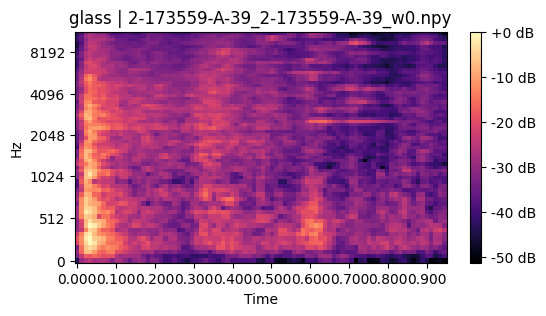

[glass] picked 2-173559-A-39_2-173559-A-39_w0.npy -> glass_sample_bchw.npy, mel=(64, 84), bchw=(1, 1, 64, 84)
[glass] audio len=0.99s | absmax=1.000 | mel JPG: cache/exports/glass_sample_mel.jpg


[gunshot] picked 4 (57)_4 (57)_w0.npy -> gunshot_sample_bchw.npy, mel=(64, 84), bchw=(1, 1, 64, 84)


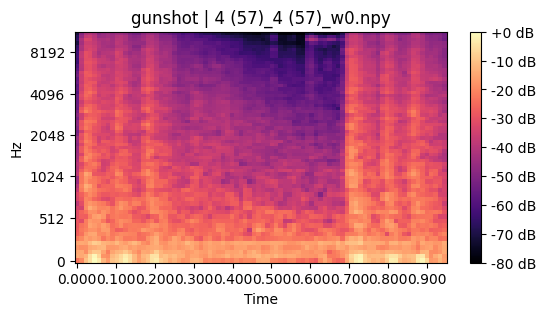

[gunshot] picked 4 (57)_4 (57)_w0.npy -> gunshot_sample_bchw.npy, mel=(64, 84), bchw=(1, 1, 64, 84)
[gunshot] audio len=0.99s | absmax=1.000 | mel JPG: cache/exports/gunshot_sample_mel.jpg


In [15]:
# Cell: Step 4 - Export random glass/gunshot window to (1,1,64,T) + playback    
for lbl in ["glass", "gunshot"]:
    mel, out_path, src = pick_and_export(lbl)
    if mel is None:
        continue

    # Mel→音频（power→Griffin-Lim），与训练一致的 sr/n_fft/hop/center
    mel_power = librosa.db_to_power(mel)
    y = librosa.feature.inverse.mel_to_audio(
        mel_power,
        sr=SR,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_iter=64,
        center=MEL_CENTER if 'MEL_CENTER' in globals() else False,
    )
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))  # 归一化，避免音量过低

    # 保存 mel 图片
    fig, ax = plt.subplots(figsize=(6, 3))
    im = librosa.display.specshow(
        mel,
        x_axis="time",
        y_axis="mel",
        sr=SR,
        hop_length=HOP_LENGTH,
        cmap="magma",
        ax=ax,
    )
    ax.set_title(f"{lbl} | {src.name}")
    fig.colorbar(im, ax=ax, format="%+0.0f dB")
    jpg_path = OUTPUT_DIR / f"{lbl}_sample_mel.jpg"
    plt.savefig(jpg_path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    # 信息+试听
    print(f"[{lbl}] picked {src.name} -> {out_path.name}, mel={mel.shape}, bchw={(1,1,*mel.shape)}")
    print(f"[{lbl}] audio len={len(y)/SR:.2f}s | absmax={np.max(np.abs(y)):.3f} | mel JPG: {jpg_path}")
    display(Audio(y, rate=SR))


In [24]:
# Caffe generation - Data Transfer
print(f'''
sudo chown -R $USER:$USER .
rsync -av cache/exports/{MODEL_NAME}.onnx /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models
ll /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/{MODEL_NAME}.onnx
''')

# Caffemodel generation
print(f'''
make -f /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/nvdla_vp.mk build-onnx2caffe MODEL_NAME={MODEL_NAME}
cp /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/{MODEL_NAME}.caffemodel cache/exports/
cp /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/{MODEL_NAME}.prototxt cache/exports/
ll cache/exports/
''')


# TRT calibration - Data Transfer
print(f'''
rsync -av cache/exports/{MODEL_NAME}.onnx nvidia@jetson:/home/nvidia/Documents/emass/NVDLA-pv-log/models/onnx/
rsync -av cache/exports/{MODEL_NAME}_calib.npz nvidia@jetson:/home/nvidia/Documents/emass/NVDLA-pv-log/data/calib/
rsync -av cache/exports/{MODEL_NAME}_eval.npz nvidia@jetson:/home/nvidia/Documents/emass/NVDLA-pv-log/data/eval/
rsync -av /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/{MODEL_NAME}.caffemodel nvidia@jetson:/home/nvidia/Documents/emass/NVDLA-pv-log/models/caffe/
rsync -av /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/{MODEL_NAME}.prototxt nvidia@jetson:/home/nvidia/Documents/emass/NVDLA-pv-log/models/caffe/
''')

# start_time=$(date +%s)
# make run CFG=configs/{MODEL_NAME}_onnx.yaml
# onnx_calib_json_path=$(find models/calib -type f -name '*calib.json' -newermt "@$start_time" -print | head -n 1)
# echo "calib file generated： $onnx_calib_json_path"

# start_time=$(date +%s)
# make -f nvidia@jetson:/home/nvidia/Documents/emass/NVDLA-pv-log/Makefile run CFG=configs/{MODEL_NAME}_caffe.yaml
# caffe_calib_json_path=$(find nvidia@jetson:/home/nvidia/Documents/emass/NVDLA-pv-log/models/calib -type f -name '*calib.json' -newermt "@$start_time" -print | head -n 1)
# echo "calib file generated： $caffe_calib_json_path"



# TRT calibration (at TRT ssh terminal)
print(f'''
make run CFG=configs/{MODEL_NAME}_onnx.yaml
make run CFG=configs/{MODEL_NAME}_caffe.yaml
''')


# Update filename After calibration here 
calib_json_onnx = "tiny-audio-net@onnx@minmax@2025-12-22T17-43-07_calib.json"
calib_json_caffe = "tiny-audio-net@caffe@minmax@2025-12-22T17-51-20_calib.json"


# Quant Inference - Data Transfer 
print(f'''
rsync -av cache/exports/gunshot_sample_bchw.npy /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/data/np/{MODEL_NAME}/
rsync -av cache/exports/glass_sample_bchw.npy /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/data/np/{MODEL_NAME}/
rsync -av cache/exports/{MODEL_NAME}_calib.npz /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/data/npz/{MODEL_NAME}/
rsync -av cache/exports/{MODEL_NAME}_eval.npz /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/data/npz/{MODEL_NAME}/
rsync -av nvidia@jetson:/home/nvidia/Documents/emass/NVDLA-pv-log/models/calib/{calib_json_onnx} /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/{MODEL_NAME}_onnx_calib.json
rsync -av nvidia@jetson:/home/nvidia/Documents/emass/NVDLA-pv-log/models/calib/{calib_json_caffe} /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/{MODEL_NAME}_caffe_calib.json
cp /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/{MODEL_NAME}_caffe_calib.json /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/{MODEL_NAME}_caffe_calib_fixed.json
''')

# Fix caffe calib json
print("manual fix caffe json here")


# Transfer calib json to export dir
print(f'''
cp /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/{MODEL_NAME}_caffe_calib_fixed.json cache/exports/
cp /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/{MODEL_NAME}_onnx_calib.json cache/exports/
ll cache/exports/
''')

# # Put export to target dir
# print(f'''
# cp cache/exports/
# cp /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/{MODEL_NAME}_onnx_calib.json cache/exports/
# ll cache/exports/
# ''')



sudo chown -R $USER:$USER .
rsync -av cache/exports/tiny-audio-net.onnx /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models
ll /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/tiny-audio-net.onnx

make -f /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/nvdla_vp.mk build-onnx2caffe MODEL_NAME=tiny-audio-net
cp /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/tiny-audio-net.caffemodel cache/exports/
cp /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/tiny-audio-net.prototxt cache/exports/
ll cache/exports/


rsync -av cache/exports/tiny-audio-net.onnx nvidia@jetson:/home/nvidia/Documents/emass/NVDLA-pv-log/models/onnx/
rsync -av cache/exports/tiny-audio-net_calib.npz nvidia@jetson:/home/nvidia/Documents/emass/NVDLA-pv-log/data/calib/
rsync -av cache/exports/tiny-audio-net_eval.npz nvidia@jetson:/home/nvidia/Documents/emass/NVDLA-pv-log/data/eval/
rsync -av /home/seakon/Documents/nvdla-log/NVDLA-pv-log/nvdla_vp/models/tiny-audio-net

In [9]:

import numpy as np
z=np.load('cache/exports/tiny-audio-net_calib.npz')
print(z.files)
print('imgs', z['imgs'].shape)
print('labels', z['labels'].shape if 'labels' in z.files else None)
print('y', z['y'].shape if 'y' in z.files else None)



['imgs', 'labels', 'y']
imgs (419, 1, 64, 84)
labels (419,)
y (419, 2)
